In [57]:
import numpy as np
import matplotlib.pyplot as plt
from EDnosym import operator
from scipy.sparse.linalg import expm_multiply

# Exercise 1: quench dynamics and eigenstate thermalization hypothesis

In this exercise, we will study the quench dynamics in a mixed-field quantum Ising chain. 
The Hamiltonian of the model has the following expression:
\begin{equation}
H=\sum_{j=0}^{L-1} (-JZ_j Z_{j+1}-gX_j-hZ_j).
\end{equation}

Here, $X$ and $Z$ are Pauli matrices, and we assume periodic boundary conditions. In our notation:
\begin{equation}
Z=|0\rangle\langle 0|-|1\rangle\langle 1|,
\end{equation}
\begin{equation}
X=|0\rangle\langle 1|+|1\rangle\langle 0|.
\end{equation}

In [58]:
Z = np.array([[1, 0],
              [0, -1]])
X = np.array([[0, 1],
              [1, 0]])

We set the parameters of the simulation:

In [59]:
J =  1
g = 0.9045
h = 0.890

In [60]:
L = 4

## Hamiltonian construction

The following line constructs the nearest-neighbor Ising interaction terms of the Hamiltonian

In [61]:
H = -J*sum([operator(sites = [j,(j+1)%L], matrices = [Z, Z], L = L) for j in range(L)])

Add to $H$ the other terms, corresponding to the transverse and longitudinal field

In [62]:
H += -g*sum([operator(sites = [j], matrices = [X], L = L) for j in range(L)])
H += -h*sum([operator(sites = [j], matrices = [Z], L = L) for j in range(L)])

## Time evolution

We initialize the system in the state $|11..\rangle$.

In [63]:
psi = np.zeros(2**L)
psi[int('1'*L, 2)] = 1 

Define Z0 as the $Z$ operator on the site $j=0$

In [64]:
Z0 = operator(sites = [0], matrices = [Z], L = L)

We set the parameters of the time evolution:

In [65]:
dt = 0.02 # timestep
Nt = 200  # number of steps
time = dt*np.arange(Nt)

We are going to measure $Z_0$ and $H$ (to check energy conservation) along the evolution. We define the empty vectors where to store their values.

In [66]:
Z0val = np.zeros(Nt)
Hval = np.zeros(Nt)

In [67]:
for i in range(Nt):
    psi = expm_multiply(-1j*H*dt, psi)
    Z0val[i] = np.vdot(psi, Z0.dot(psi)).real
    Hval[i] = np.vdot(psi, H.dot(psi)).real

Check that the final norm of psi is still 1

In [68]:
norm = np.vdot(psi,psi)
print(norm)

(1.0000000000000038+0j)


## Results

Plot Hval vs time

Text(0, 0.5, 'Energy')

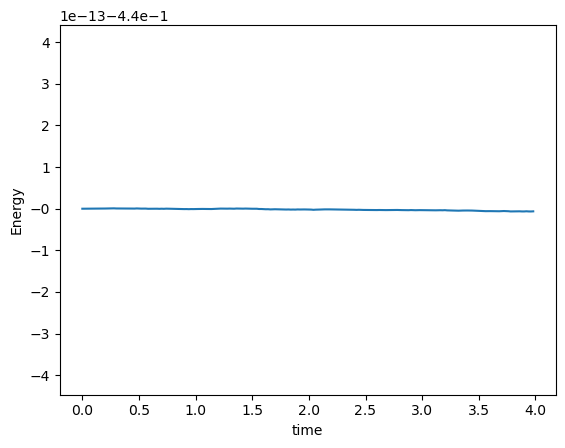

In [69]:
plt.plot(time, Hval)
plt.xlabel('time')
plt.ylabel('Energy')

Plot Z0val vs time

Text(0, 0.5, '$Z_0$')

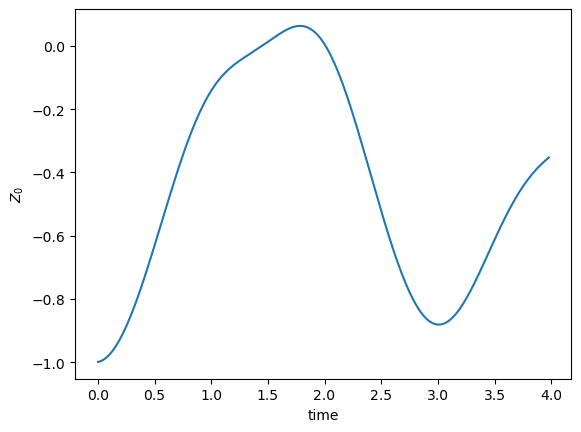

In [70]:
plt.plot(time, Z0val)
plt.xlabel('time')
plt.ylabel('$Z_0$')

## Dependence on system size

Plot Z0val vs time for $L=4,6,8,10,12$. What do you observe?

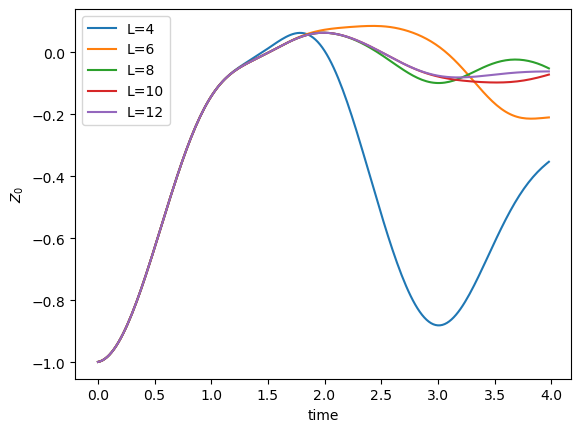

In [71]:
for L in range(4, 14, 2):
    H = -J*sum([operator(sites = [j,(j+1)%L], matrices = [Z, Z], L = L) for j in range(L)])
    H += -g*sum([operator(sites = [j], matrices = [X], L = L) for j in range(L)])
    H += -h*sum([operator(sites = [j], matrices = [Z], L = L) for j in range(L)])
    
    psi = np.zeros(2**L)
    psi[int('1'*(L), 2)] = 1 
    Z0 = operator(sites = [0], matrices = [Z], L = L)
    
    dt = 0.02 # timestep
    Nt = 200  # number of steps
    time = dt*np.arange(Nt)
    
    Z0val = np.zeros(Nt)
    for i in range(Nt):
        psi = expm_multiply(-1j*H*dt, psi)
        Z0val[i] = np.vdot(psi, Z0.dot(psi)).real
    plt.plot(time, Z0val, label=f'L={L}')
plt.xlabel('time')
plt.ylabel(r'$Z_0$')
plt.legend()

This result shows one important aspect in the definition of thermal equilibrium: we first have to take the thermodynamic limit $L\rightarrow \infty$ before taking the infinite time limit.


## Eigenstate thermalization

Now we will see what eigenstate thermalization hypothesis can teach us about the quench dynamics above. We will start by computing the expectation value according to the diagonal ensemble.

We start by constructing $H$ for $L=12$, as we did above.

In [72]:
L=12

H = -J*sum([operator(sites = [j,(j+1)%L], matrices = [Z, Z], L = L) for j in range(L)])
H += -g*sum([operator(sites = [j], matrices = [X], L = L) for j in range(L)])
H += -h*sum([operator(sites = [j], matrices = [Z], L = L) for j in range(L)])

The Hamiltonian $H$ is defined as a sparse matrix. To perform full diagonalization, we first have to transform it to a dense matrix:

In [73]:
Hdense = H.toarray()
eigvals, eigvec = np.linalg.eigh(Hdense)

We then compute the overlaps $C_n$ of the initial state with the energy eigenstates, and plot $|C_n|$ as a function of the energy eigenvalues $E_n$. Show that the overlaps $|C_n|$ are peaked around $E_0=\langle \psi_0|H|\psi_0\rangle$.

In [74]:
psi = np.zeros(2**L)
psi[int('1'*L, 2)] = 1 

cn = np.abs(eigvec.T.conj().dot(psi))

In [75]:
E0 = np.vdot(psi, H.dot(psi))

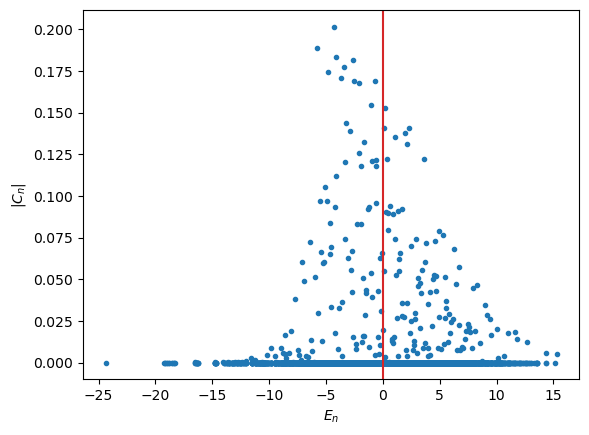

In [76]:
plt.plot(eigvals, cn, '.')
plt.xlabel(r'$E_n$')
plt.ylabel(r'$|C_n|$')
plt.axvline(E, color='C3')

Now we construct $Z_0$, and use the eigenvectors that we just computed to transform it from the computational basis to the energy eigenbasis.

In [77]:
Z0 = operator(sites = [0], matrices = [Z], L = L)
Z0nm = eigvec.T.conj().dot(Z0.dot(eigvec))

Now we can compute the expectation value of $Z_0$ according to the diagonal ensemble.

In [78]:
Z0_DE = np.sum(cn**2*Z0nm.diagonal())

Plot the diagonal elements $(Z_0)_{nn}$ vs $E_n$. They have a smooth dependence according to ETH. Indicate in the plot the energy $E_0$ and the prediction $(Z_0)_{DE}$ of the diagonal ensemble. Does the prediction of the diagonal ensemble agree with ETH?

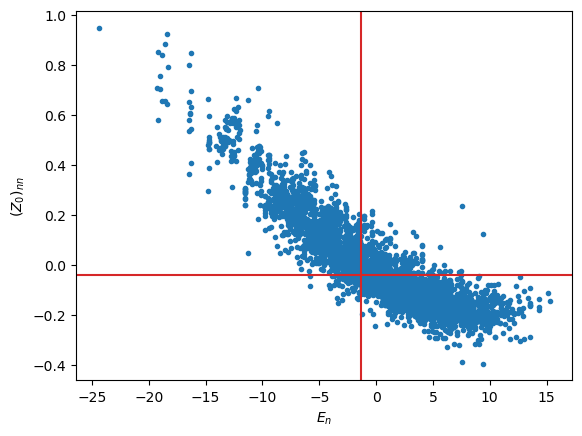

In [79]:
plt.plot(eigvals, Z0nm.diagonal(), '.')
plt.xlabel(r'$E_n$')
plt.ylabel(r'$(Z_0)_{nn}$')
plt.axvline(E0, color='C3')
plt.axhline(Z0_DE, color='C3')

The matrix elements $Z_{nn}$ that we are plotting here do not all contribute to the diagonal ensemble. In fact, due to symmetries, many energy eigenstates have zero overlap with the initial state. To check it, plot $|C_n|$ vs $E_n$ in y-log scale and identify the indices of the eigenstates that have nonzero overlap with the initial state.

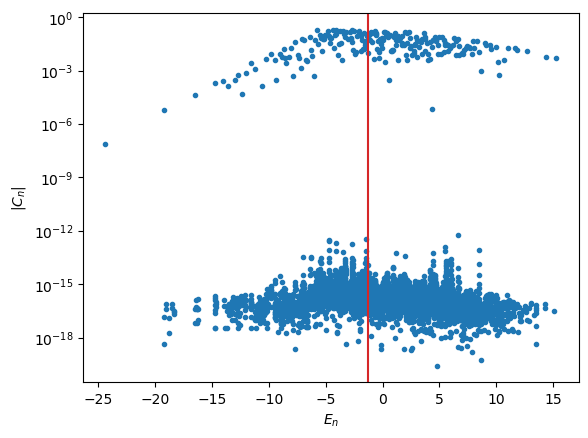

In [80]:
plt.plot(eigvals, cn, '.')
plt.yscale('log')
plt.xlabel(r'$E_n$')
plt.ylabel(r'$|C_n|$')
plt.axvline(E0, color='C3')

In [81]:
nonzero_indices = np.where(cn>1e-9)[0]

Now plot the diagonal elements $(Z_0)_{nn}$ vs $E_n$ including only the indices corresponding to states with nonzero overlaps.

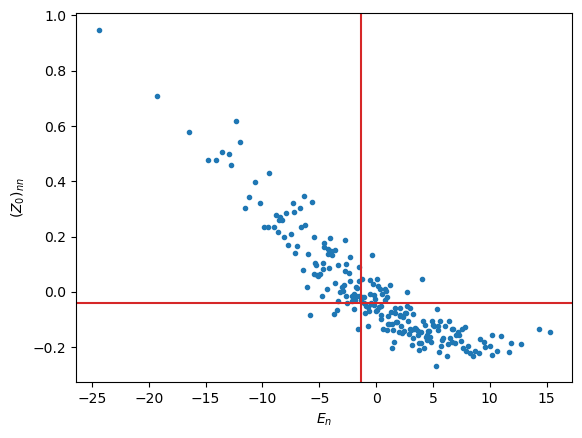

In [82]:
plt.plot(eigvals[nonzero_indices], Z0nm[nonzero_indices, nonzero_indices], '.')
plt.xlabel(r'$E_n$')
plt.ylabel(r'$(Z_0)_{nn}$')
plt.axvline(E0, color='C3')
plt.axhline(Z0_DE, color='C3')

### Bonus: off-diagonal part

Now we are going to examine the off-diagonal elements $(Z_0)_{nm}$. For simplicity, let us restrict to indices corresponding to eigenstates with non-zero overlap with $\psi_0$.

In [83]:
Z0_sector = Z0nm[nonzero_indices][:, nonzero_indices]
eigvals_sector = eigvals[nonzero_indices]

Plot the absolute value of $(Z_0)_{nm}$ as a 2D-plot, with $E_n$, $E_m$ on the axes.

Text(0, 0.5, '$E_m$')

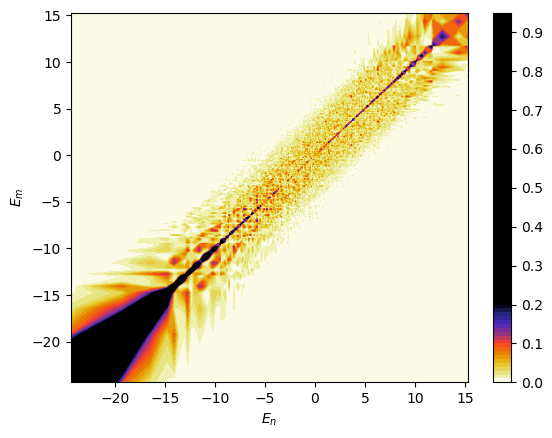

In [87]:
En, Em =np.meshgrid(eigvals_sector, eigvals_sector)
plt.contourf(En, Em,\
             np.abs(Z0_sector), cmap='CMRmap_r', levels=100, vmax=0.2)
plt.colorbar()
plt.xlabel(r'$E_n$')
plt.ylabel(r'$E_m$')

We define the variables $\overline{E}_{nm}=(E_n+E_m)/2$ and $\omega_{nm}=E_n-E_m$.

In [88]:
Ebar = (En+Em)/2
omega = En-Em

Plot the matrix element $(Z_0)_{nm}$ as a function of $\omega_{nm}$ for states in an energy window $\overline E_{nm} \in [E-dE, E+dE]$. What is the dependence of $f_{Z_0}(E, \omega)$ at large $\omega$?

Text(0, 0.5, '$Z_{nm}$')

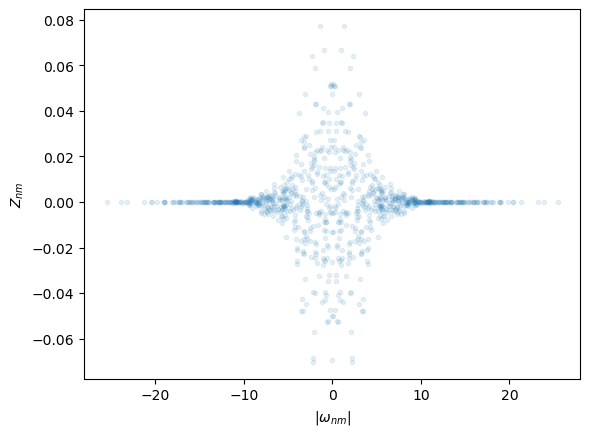

In [94]:
E = 0.0
dE =0.1
E_filter = np.where(np.abs(Ebar-E).flatten()<dE)[0]
plt.plot(omega.flatten()[E_filter],\
            Z0_sector.flatten()[E_filter], '.', alpha=0.1)
plt.xlabel(r'$|\omega_{nm}|$')
plt.ylabel(r'$Z_{nm}$')

Text(0, 0.5, '$Z_{nm}$')

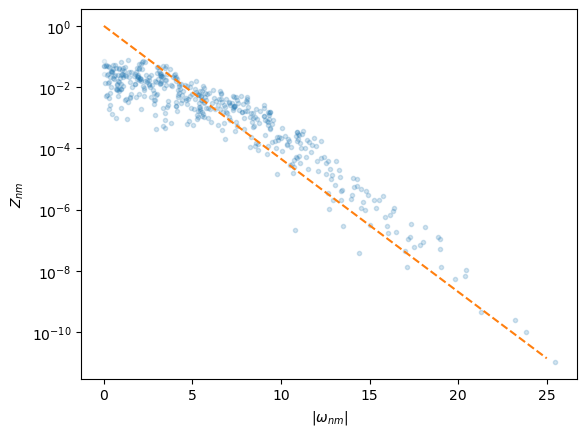

In [98]:
E = 0
dE =0.1
E_filter = np.where(np.abs(Ebar-E).flatten()<dE)[0]
plt.plot(np.abs(omega).flatten()[E_filter],\
            np.abs(Z0_sector).flatten()[E_filter], '.', alpha=0.1)
plt.yscale('log')
x = np.linspace(0, 25)
plt.plot(x, np.exp(-x), ls='--')
plt.xlabel(r'$|\omega_{nm}|$')
plt.ylabel(r'$Z_{nm}$')